In [1]:
#!pip install wordcloud

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split

In [2]:
## Preprocesamiento

In [3]:
reviews = pd.read_csv('reviews.csv', delimiter=',')

In [4]:
print("Tamaño del conjunto de datos:", len(reviews))

Tamaño del conjunto de datos: 20491


In [5]:
## Veamos una muestra del conjunto de datos
reviews.sample(5)

,Review,Rating
20133,"best best best, great vast choice offood priss...",5
6712,great money understand mixed reviews grand oas...,4
360,perfect read past reviews hotel booking rooms ...,5
19423,excelent location service pleasantly surprised...,5
5483,reasonable place stay stayed 2004 elevator not...,4


In [6]:
## Vemos los posibles reviews que podemos obtener
reviews['Rating'].unique()

array([4, 2, 3, 5, 1])

In [7]:
# Buscamos a ver si hay reviews/ratings nulos.
# Vemos que no hay calificaciones vacías
reviews[reviews['Review'] == ""]

,Review,Rating


In [8]:
# También podemos usar los métodos de pandas
reviews.isna().sum()

Review    0
Rating    0
dtype: int64

In [9]:
# No tenemos ningún dato nulo ni vacío.
reviews.isnull().sum()

Review    0
Rating    0
dtype: int64

In [10]:
## Partimos el conjunto de datos en train y test
X, y = reviews['Review'], reviews['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=48)

In [11]:
## Vemos ahora la distribución de las clases 
df = y_train.value_counts()

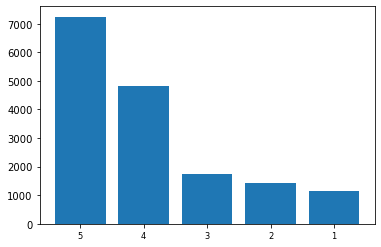

In [12]:
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.show()

Vemos que las clases están desbalanceadas. Entonces, debemos usar técnicas de balanceo. Podemos hacerlo en preprocesamiento y en modelo. Primero, lo intentaremos en preprocesamiento y haremos oversampling usando SMOTE. Esto lo haremos después. 

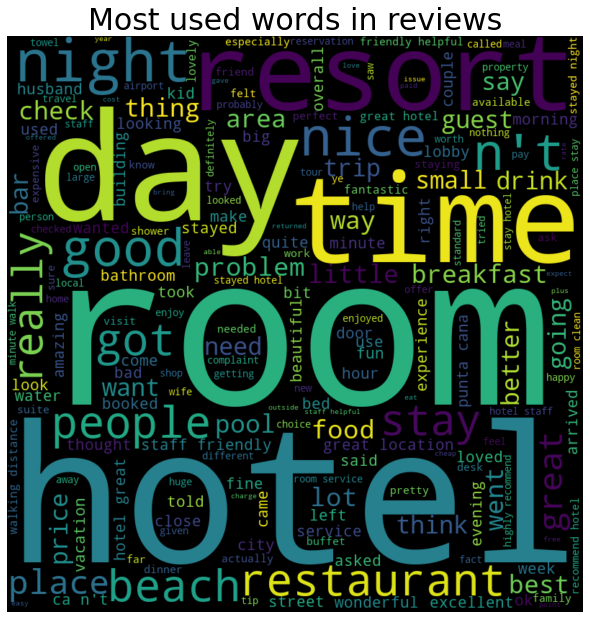

In [13]:
# Una forma chévere de ver las palabras más usadas es con una nube de palabras. Esto nos permite tener un mejor
# entendimiento del problema.
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

wordCloud_generator(X_train, title="Most used words in reviews")

In [ ]:
# se hace necesario corregir algunas palabras que notamos con n't



In [14]:
import nltk
#!pip install contractions
#!pip install inflect
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [15]:
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [16]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [17]:
new_X_train= X_train.apply(contractions.fix) #Aplica la corrección de las contracciones
new_X_train = new_X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preproccesing) #Aplica la eliminación del ruido
new_X_train.head()

2655     [westin, rio, mar, worth, trip, friend, return...
2653     [loved, westin, read, reviews, daily, westin, ...
10205    [simply, amazing, stayed, zero, nights, nov, 2...
12505    [fantastic, vacation, wife, son, daughterinlaw...
20447    [really, nice, hotel, stayed, 2, nights, singa...
Name: Review, dtype: object

In [18]:
wordCloud_generator(new_X_train, title="Most used words in reviews")

TypeError: sequence item 0: expected str instance, list found

2655     westin rio mar worth trip friend just returned...
2653     loved westin read reviews daily westin ca n't ...
10205    simply amazing, stayed zero nights nov 21-22 2...
12505    fantastic vacation wife son daughter-in-law be...
20447    really nice hotel stayed 2 nights singapore ai...
                               ...                        
7333     stay away stay leaving orlando reservations st...
19548    absolutely loved mela stayed mela 2007 christm...
9640     great friendly service staff great location ro...
20352    mice room husband stayed museum hotel month st...
2845     great time paradisus spa resort husband just r...
Name: Review, Length: 16392, dtype: object

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

new_X_train = new_X_train.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
new_X_train.head()

In [ ]:
X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
X_train